# Binary Classification using PyTorch: Resnet-101 illustrating Transfer Learning baseline 

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/hymenoptera-data/hymenoptera_data/hymenoptera_data/val/ants/2219621907_47bc7cc6b0.jpg
/kaggle/input/hymenoptera-data/hymenoptera_data/hymenoptera_data/val/ants/183260961_64ab754c97.jpg
/kaggle/input/hymenoptera-data/hymenoptera_data/hymenoptera_data/val/ants/892676922_4ab37dce07.jpg
/kaggle/input/hymenoptera-data/hymenoptera_data/hymenoptera_data/val/ants/147542264_79506478c2.jpg
/kaggle/input/hymenoptera-data/hymenoptera_data/hymenoptera_data/val/ants/8124241_36b290d372.jpg
/kaggle/input/hymenoptera-data/hymenoptera_data/hymenoptera_data/val/ants/751649788_78dd7d16ce.jpg
/kaggle/input/hymenoptera-data/hymenoptera_data/hymenoptera_data/val/ants/1119630822_cd325ea21a.jpg
/kaggle/input/hymenoptera-data/hymenoptera_data/hymenoptera_data/val/ants/161292361_c16e0bf57a.jpg
/kaggle/input/hymenoptera-data/hymenoptera_data/hymenoptera_data/val/ants/172772109_d0a8e15fb0.jpg
/kaggle/input/hymenoptera-data/hymenoptera_data/hymenoptera_data/val/ants/1743840368_b5ccda82b7.jpg
/kaggle/i

## Importing libraries and modules

In [2]:
!pip -qq install split-folders tqdm

In [3]:
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import random
import splitfolders
import shutil

print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  1.7.0
Torchvision Version:  0.8.1


## Basic setting configuration

In [4]:
data = '../input/hymenoptera-data/hymenoptera_data'
num_classes = 2
num_epochs = 30

# When feature)Extract = False, we finetune the complete model, else we only update the reshaped layer params.
# try this with feature_extract = False
feature_extract = True 

batch_size = 8

## Seed everything

In [5]:
seed = 42
print(f'setting everything to seed {seed}')
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

setting everything to seed 42


## Load and Transforming the data

In [6]:
# Data Augmentation and Normalization for training
# For Validation, we will only normalize the data
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

# Create training and validation datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(data, x), data_transforms[x]) for x in ['train', 'val']}
# Dataloaders are created from the datasets
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'val']}

device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')

## Simple Visualization

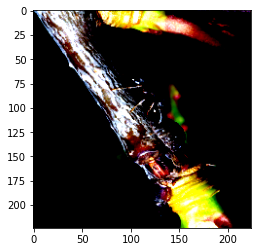

0 ants


In [7]:
image,label = image_datasets['train'][15]
plt.imshow(image.permute(2,1,0))
plt.show()
print(label, image_datasets['train'].classes[label])

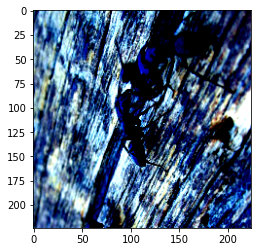

0 ants


In [8]:
image,label = image_datasets['train'][50]
plt.imshow(image.permute(2,1,0))
plt.show()
print(label, image_datasets['train'].classes[label])

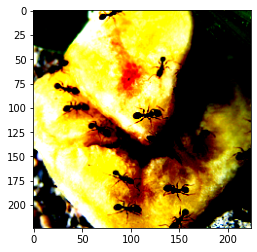

0 ants


In [9]:
image,label = image_datasets['val'][50]
plt.imshow(image.permute(2,1,0))
plt.show()
print(label, image_datasets['val'].classes[label])

## Data Distribution

In [10]:
labels = image_datasets['train'].targets
_,labels_count = np.unique(labels, return_counts=True)
labels_count

array([123, 121])

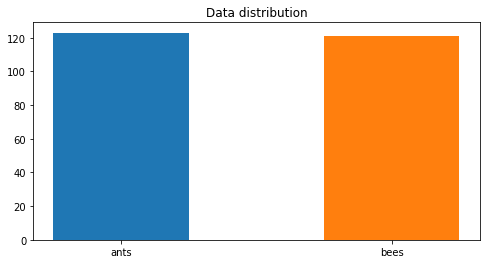

In [11]:
class_names = image_datasets['train'].classes

plt.figure(figsize=(8, 4))
plt.title('Data distribution')
plt.bar(class_names, labels_count, width=.5, color = ['C0', 'C1'])
plt.show()

## Parameter optimization check

In [12]:
# Feature extracting = True -> requires_grad = False
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

## Model Initialization

In [13]:
def initialize_model(num_classes, feature_extract, use_pretrained=True):
    model = None
    input_size = 0
    
    model = models.resnet101(pretrained=use_pretrained)
    set_parameter_requires_grad(model, feature_extract)
    num_features = model.fc.in_features
    model.fc = nn.Linear(num_features, num_classes)
    input_size = 224
    
    return model

Model here has been initialized and sent to GPU

In [14]:
model = initialize_model(num_classes, feature_extract)

model = model.to(device)

Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /root/.cache/torch/hub/checkpoints/resnet101-5d3b4d8f.pth


  0%|          | 0.00/170M [00:00<?, ?B/s]

## Optimizing parameters of the model

Depends on feature_extract == {True or False}

In [15]:
# Gather the parameters to be optimized/updated in this run. If we are
# finetuning we will be updating all parameters. However, if we are
# doing feature extract method, we will only update the parameters
# that we have just initialized, i.e. the parameters with requires_grad
# is True.
params_to_update = model.parameters()
if feature_extract:
    params_to_update = []
    for name, param in model.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print(name)
else:
    for name, param in model.named_parameters():
        if param.requires_grad:
            print(name)

# The parameters are optimizing
optimizer = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

fc.weight
fc.bias


## Model training phase

In [16]:
# Loss function
criterion = nn.CrossEntropyLoss()

In [17]:
def train_model(model, dataloaders, optimizer, criterion=criterion, num_epochs=num_epochs, is_inception=False):
    start = time.time()
    val_acc_history = []
    
    best_model_weights = copy.deepcopy(model.state_dict())
    best_acc = 0
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-'*10)
        
        # Each epoch's training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()   # Do this if model is in training phase
            else:
                model.eval()    # Do this if model is in validation phase
                
            running_loss = 0
            running_corrects = 0
            
            # Iteration over the data
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # Parameter gradients are initialized to 0
                optimizer.zero_grad()
                
                # Forward Pass
                # Getting model outputs and calculating loss
                with torch.set_grad_enabled(phase == 'train'):
                    if is_inception and phase == 'train':      # Special case of inception because InceptionV3 has auxillary outputs as well. 
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)
                        
                    _, preds = torch.max(outputs, 1)
                    
                    # Backward pass and Optimization in training phase 
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                # Stats
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds==labels.data)
                
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            
            # Deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_weights = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)
                
    time_elapsed = time.time()
    
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    
    # Best model weights are loaded here
    model.load_state_dict(best_model_weights)
    return model, val_acc_history

In [18]:
model, history = train_model(model, dataloaders_dict, optimizer, criterion, num_epochs, False)

Epoch 0/29
----------
train Loss: 0.6634 Acc: 0.6189
val Loss: 0.2883 Acc: 0.9150
Epoch 1/29
----------
train Loss: 0.2961 Acc: 0.9016
val Loss: 0.2265 Acc: 0.9020
Epoch 2/29
----------
train Loss: 0.2641 Acc: 0.8770
val Loss: 0.1803 Acc: 0.9281
Epoch 3/29
----------
train Loss: 0.2838 Acc: 0.8852
val Loss: 0.1528 Acc: 0.9477
Epoch 4/29
----------
train Loss: 0.2437 Acc: 0.9221
val Loss: 0.1501 Acc: 0.9477
Epoch 5/29
----------
train Loss: 0.2779 Acc: 0.8730
val Loss: 0.1915 Acc: 0.9281
Epoch 6/29
----------
train Loss: 0.2335 Acc: 0.8893
val Loss: 0.1529 Acc: 0.9477
Epoch 7/29
----------
train Loss: 0.3014 Acc: 0.8566
val Loss: 0.1795 Acc: 0.9281
Epoch 8/29
----------
train Loss: 0.2413 Acc: 0.9016
val Loss: 0.3199 Acc: 0.8758
Epoch 9/29
----------
train Loss: 0.1629 Acc: 0.9508
val Loss: 0.1649 Acc: 0.9412
Epoch 10/29
----------
train Loss: 0.1712 Acc: 0.9508
val Loss: 0.1477 Acc: 0.9477
Epoch 11/29
----------
train Loss: 0.1908 Acc: 0.9139
val Loss: 0.1439 Acc: 0.9477
Epoch 12/29
--

## Initializng model with feature_extract = False

In [19]:
model_nft = initialize_model(num_classes, feature_extract=False)

model_nft = model_nft.to(device)

When feature extract is false, the complete model will be fine-tuned.

In [20]:
feature_extract = False
params_to_update = model_nft.parameters()
if feature_extract:
    params_to_update = []
    for name, param in model_nft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print(name)
else:
    for name, param in model_nft.named_parameters():
        if param.requires_grad:
            print(name)
            
optimizer = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

conv1.weight
bn1.weight
bn1.bias
layer1.0.conv1.weight
layer1.0.bn1.weight
layer1.0.bn1.bias
layer1.0.conv2.weight
layer1.0.bn2.weight
layer1.0.bn2.bias
layer1.0.conv3.weight
layer1.0.bn3.weight
layer1.0.bn3.bias
layer1.0.downsample.0.weight
layer1.0.downsample.1.weight
layer1.0.downsample.1.bias
layer1.1.conv1.weight
layer1.1.bn1.weight
layer1.1.bn1.bias
layer1.1.conv2.weight
layer1.1.bn2.weight
layer1.1.bn2.bias
layer1.1.conv3.weight
layer1.1.bn3.weight
layer1.1.bn3.bias
layer1.2.conv1.weight
layer1.2.bn1.weight
layer1.2.bn1.bias
layer1.2.conv2.weight
layer1.2.bn2.weight
layer1.2.bn2.bias
layer1.2.conv3.weight
layer1.2.bn3.weight
layer1.2.bn3.bias
layer2.0.conv1.weight
layer2.0.bn1.weight
layer2.0.bn1.bias
layer2.0.conv2.weight
layer2.0.bn2.weight
layer2.0.bn2.bias
layer2.0.conv3.weight
layer2.0.bn3.weight
layer2.0.bn3.bias
layer2.0.downsample.0.weight
layer2.0.downsample.1.weight
layer2.0.downsample.1.bias
layer2.1.conv1.weight
layer2.1.bn1.weight
layer2.1.bn1.bias
layer2.1.conv2.we

## Training the model with feature_extract = False

In [21]:
model_nft, history_nft = train_model(model_nft, dataloaders_dict, optimizer, criterion, num_epochs, False)

Epoch 0/29
----------
train Loss: 0.5624 Acc: 0.6762
val Loss: 0.2794 Acc: 0.9085
Epoch 1/29
----------
train Loss: 0.3398 Acc: 0.8443
val Loss: 0.1356 Acc: 0.9412
Epoch 2/29
----------
train Loss: 0.1876 Acc: 0.9057
val Loss: 0.1784 Acc: 0.9346
Epoch 3/29
----------
train Loss: 0.1695 Acc: 0.9057
val Loss: 0.1281 Acc: 0.9412
Epoch 4/29
----------
train Loss: 0.1958 Acc: 0.9221
val Loss: 0.2079 Acc: 0.9346
Epoch 5/29
----------
train Loss: 0.1495 Acc: 0.9426
val Loss: 0.3827 Acc: 0.8693
Epoch 6/29
----------
train Loss: 0.1704 Acc: 0.9303
val Loss: 0.1742 Acc: 0.9346
Epoch 7/29
----------
train Loss: 0.1203 Acc: 0.9508
val Loss: 0.1916 Acc: 0.9346
Epoch 8/29
----------
train Loss: 0.1173 Acc: 0.9549
val Loss: 0.1886 Acc: 0.9281
Epoch 9/29
----------
train Loss: 0.1317 Acc: 0.9508
val Loss: 0.2363 Acc: 0.9216
Epoch 10/29
----------
train Loss: 0.1218 Acc: 0.9590
val Loss: 0.2178 Acc: 0.9346
Epoch 11/29
----------
train Loss: 0.1375 Acc: 0.9467
val Loss: 0.3145 Acc: 0.9020
Epoch 12/29
--

# Hope you like this notebook!
## Please Upvote